# Oscillators

<hr>

This course is derived from the course Biological Circuit Design by Michael Elowitz and Justin Bois, 2020 at Caltech. The original course material has been changed by Matthias Fuegger and Thomas Nowak.

<hr />

**References for today's lecture**

- [Elowitz & Leibler, A synthetic oscillatory network of transcriptional regulators, *Nature*, 2000](https://doi.org/10.1038/35002125)
- [Synchronous long-term oscillations in a synthetic gene circuit, *Nature*, 2016](https://doi.org/10.1038/nature19841) 

<hr />

In [2]:
import numpy as np
import scipy.integrate
import scipy.optimize


import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

figsize=(6, 4.5)

<hr />

## Today's topic: designing cellular clocks

Today we will talk about how to build a clock in a living cell. More specifically, we will discuss a synthetic genetic clock circuit called the Repressilator ([Elowitz & Leibler, Nature, 2000](https://doi.org/10.1038/35002125)). We  first discuss the important roles of oscillators and clocks in natural biological systems, and then ask how one might go about designing a synthetic clock circuit that can operate in a living cell. To do this, we will use **linear stability analysis**, a broadly useful approach for analyzing diverse systems. We will also introduce the concept of a **limit cycle**, which is an additional, and more dynamic, type of "attractor" compared to the fixed points that we have encountered so far. 

## Clocks are ubiquitous

Modern life depends on accurate time-keeping, which has been enabled by relentless invention and improvement of mechanical and electronic clocks. For example, one of the major turning points in global navigation was the development of mechanical, temperature-compensated clocks to address the challenge of measuring longitude at sea. Notably, [John Harrison](https://en.wikipedia.org/wiki/John_Harrison) engineered an amazing and beautiful series of clocks, or "marine chronometers," of increasing precision for this purpose. Fast forward to today, and we find our daily navigation through the mean streets of Los Angeles, across smaller distances and usually at far slower speeds depends on the even more precise atomic clocks that operate on satellites to enable the global positioning system (GPS).

<div style="width: 600px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/H1_and_GPS.png" alt="H1 and GPS">
</figure>

</div>


## Clocks function within cells and organisms

Meanwhile, as living organisms, we are controlled by clocks of many kinds. Circadian clocks control our 24 hour cycles of sleep, hunger, and activity. Humans confined to environments in constant conditions exhibit free running activity cycles with 24hr (or, more accurately, a [24.18 hour](https://doi.org/10.1126/science.284.5423.2177) periods). Our clocks do not just respond to light and temperature cycles, but constitute free-running clocks that adjust all too slowly to external inputs as we fly across time zones. 

The **cell cycle** represents another kind of oscillator that takes cells through repetitive cycles of growth and division. Hormones cycle on a range of timescales from hours to weeks. Plants contain circadian and seasonal clocks that control their movement and flowering, in response to time as well as light, temperature and other inputs. 

Can we understand how these biological clocks work? In 1971, Ronald Konopka and Seymour Benzer [identified mutations that altered the circadian behavioral rhythms of fruit flies](https://doi.org/10.1073/pnas.68.9.2112). Over the last few decades, biologists have discovered key molecular components that enable these clocks to function. These include transcription factors, light sensors, and other components. In multicellular organisms, clocks synchronize between cells and organs. However, clocks are not a multicellular phenomenon: Even single cell cyanobacteria have precise, [cell-autonomous](https://doi.org/10.1038/nature02533) circadian clocks. And analysis of oscillations in individual mammalian cells indicates that they can still exhibit [circadian oscillations](https://doi.org/10.1016/0896-6273%2895%2990214-7), as one can see in [this movie](figs/independent_circadian_neurons.mov) and time traces of individual fibroblasts, showing robust cycling as well as cell-cell variability in period and phase, from D. Welsh, et al. ([*Current Biology* 2004](https://doi.org/10.1016/j.cub.2004.11.057)). 

<div style="margin: auto; width: 400px;">

<video src="figs/independent_circadian_neurons.mov" style="width: 400px;" controls>Your browser does not support display of this video.</video>

</div>

Based on the movie, we can look at time courses of singe cell oscillations.

<div style="width: 500px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/Welsh_circadian_single_cells.jpg" alt="Welsh circadian single cells">
</figure>

</div>

Efforts from many labs have now identified many  key biological components and interactions that generate circadian rhythms, culminating in the [2017 Nobel prize](https://www.nobelprize.org/prizes/medicine/2017/press-release/) to  Jeffrey C. Hall, Michael Rosbash and Michael W. Young "for their discoveries about how internal clocks and biological rhythms govern human life." One of the simplest clocks exists in cyanobacteria, where Kondo and colleagues showed in 2005 that [three proteins plus ATP](https://doi.org/10.1126/science.1108451) could, remarkably, biochemically reconstitute core clock oscillations in vitro through a circuit mechanism subsequently explained by Rust, et al. involving [ordered phosphorylation and feedback](https://doi.org/10.1126/science.1148596).

## Can one design and build a synthetic clock inside a cell?

Here we will ask a very simple question: What kind of biological circuit is sufficient to generate a clock that operates reliably in a single cell. Designing and building a clock "from scratch" is a **synthetic biology** approach that helps us identify the fundamental design principles underlying clock design, and address questions such as:

* How "hard" is it to build a biological clock? 
* How precise can a biological clock be?
* What minimum circuit designs are sufficient to generate self-sustaining oscillations?
* What tradeoffs exist between alternative clock circuit designs?

In addition, synthetic clocks provide modules for engineering more complex cellular behaviors. 

## Limit cycles are ideal dynamical behaviors for clocks

Previously in this course, we have discussed only one kind of "attractor" -- the stable fixed point. When a system sits at a stable fixed point, it does not change over time. By contrast, in a functioning clock circuit, the state of the system constantly changes in a periodic fashion, progressing through a cyclic sequence of "phases" that returns it to its starting point without external input. For an ideal clock, perturbations that we might expect to occur in a cell, such as fluctuations in the abundance of cellular components, should generate minimal perturbations to the clock dynamics, which should ultimately return to the same cycle.

In other words, we want to design a system that "has to" oscillate, that cannot do anything else.

The kind of behavior we are looking for is called a [**limit cycle**](https://en.wikipedia.org/wiki/Limit_cycle). Stable limit cycles are defined by Strogatz as "isolated closed orbits", meaning that the system goes around the limit cycle, and that neighboring points ultimately feed into the limit cycle. If the system is on a limit cycle, then it will ultimately return to the limit cycle after small perturbations, as sketched here:

<div style="width: 500px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/limit_cycles.png" alt="limit cycles">
</figure>

</div>


Note that one can also have unstable limit cycles. Also, as Strogatz notes, linear systems such as a frictionless pendulum can produce a family of orbits but not a limit cycle, because multiplying any solution of $\dot{\mathbf{x}}=\mathsf{A} \cdot \mathbf{x}$ by a constant produces another solution.

## General design framework: limit cycle dynamics across a broad range of parameter values

Our first design requirement for the synthetic clock is that **it should produce limit cycle oscillations**.

In addition to generating limit cycle oscillations, our clock circuit should also **oscillate across a broad range of biochemical parameter values.**  This is because we may not be able to exactly know or control many cellular parameters, which can and do fluctuate, as we will discuss in the context of stochastic "noise."

## Practical design constraints: use modular, well-characterized components

In synthetic biology, we do not have the level of understanding or control that is available to evolution. We know a good deal about some kinds of components, and much less about many others. Among the best characterized regulatory components in biology are prokaryotic (bacterial) transcriptional repressors and their cognate target promoters. These components are also **modular** and **composable**. By modular, we mean that they can be taken out of their natural context and used to generate a new regulatory circuit. Composability is a stronger form of modularity in which a set of components can regulate each other in the  same way. For instance, transcription factors are composable because any one can be engineered to regulate any other simply by combining corresponding target promoter sequences with open reading frames for the transcription factors. 

(Transcriptional activators, which we have already encountered, are also excellent components for synthetic design although, at the time this work was done, there were generally fewer examples that were as well-understood as repressors. Therefore, we will focus below on a circuit design built exclusively from repressors).

## Design strategy:

Based on the considerations above, we will try to design a biological circuit that generates **limit cycle oscillations** across a **broad range of biochemical parameter values** using the well-characterized composable **transcriptional repressors**. 

One of the first designs one can imagine building with repressors is a  "rock-scissors-paper" feedback loop composed of three repressors, each of which represses the next one, in a cycle:

<div style="width: 200px; margin: auto;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/rock_scissors_paper.png" alt="rock paper scissors">
</figure>

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/simple_repressilator_diagram.png" alt="repressilator diagram">
</figure>

</div>


This diagram refers to three specific repressors, TetR, λ cI, and LacI. We will discuss the rationale for choosing these below, after we work out the design. For now, the names of the repressors are unimportant, so we will call them repressor 1, 2, and 3. Repressor 1 represses production of repressor 2, which in turn represses production of repressor 3.  Finally, repressor 3 represses production or repressor 1, completing the loop.

<div style="width: 150px; margin: auto;">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/simple_repressilator_numbers.png" alt="simple repressilator numbers">
</figure>

</div>


This design is a three-component negative feedback loop (analogous to a "three ring oscillator" in electronics). If one were to turn up the level of the first protein in this system, it would lead to a decrease in the second, which would cause an increase in the third, and finally a decrease in the first. Thus, one can see, intuitively, that this system produces a negative feedback that tends to push back in the opposite direction to any perturbation, after the delay required to propagate the perturbation around the loop. 

We can try to work out the dynamics of this system by intuitive reasoning. We might achieve a limit cycle oscillation: Say that initially repressor 1 has high copy number and repressors 2 and 3 are low. The high copy of number of repressor 1 will keep the numbers of repressor 2 down. This means that repressor 3 is free to be expressed.  As its copy number grows, it will start to repress repressor 1.  As repressor 1 goes down, repressor 2 is expressed in higher numbers.  The increased repressor 2 copy number leads to less repressor 3.  Then, repressor 1 comes back up again.  So, we see a cycle, where repressor 1 is high, then repressor 3, and finally repressor 2. 

However, this behavior is by no means guaranteed. We might equally well just get a stable steady state, where all three repressors evolve to intermediate values, each sufficient to keep its target repressor at the appropriate level to maintain its target at its steady-state level. This behavior would be much more boring. 

In fact, both behaviors are possible.

So, our questions are now: 

1. What kinds of behaviors does this circuit produce?
2. How can we engineer the circuit to favor, or guarantee, limit cycle oscillations?

## Dynamical equations for the repressilator

To analyze the repressilator, we will write down our usual differential equations. For simplicity, we will assume symmetry among the species (this will not be true in the real system) and, initially, we will consider only protein dynamics, ignoring mRNA. Later on, we will ask how including mRNA modifies the conclusions.

\begin{align}
\frac{\mathrm{d}x_1}{\mathrm{d}t} &= \frac{\beta}{1 + (x_3/k)^n} - \gamma x_1, \\[1em]
\frac{\mathrm{d}x_2}{\mathrm{d}t} &= \frac{\beta}{1 + (x_1/k)^n} - \gamma x_2, \\[1em]
\frac{\mathrm{d}x_3}{\mathrm{d}t} &= \frac{\beta}{1 + (x_2/k)^n} - \gamma x_3.
\end{align}

In dimensionless units, this is

\begin{align}
\frac{\mathrm{d}x_i}{\mathrm{d}t} &= \frac{\beta}{1 + x_j^n} - x_i, \quad \text{ for } (i,j) \in \{(1,3), (2,1), (3,2)\}.
\end{align}

### Fixed point

To find the fixed point of the repressilator, we solve for $x_i$ with $\dot{x}_i = 0$.  We get that

\begin{align}
x_1 &= \frac{\beta}{1+x_3^n}, \\[1em]
x_2 &= \frac{\beta}{1+x_1^n}, \\[1em]
x_3 &= \frac{\beta}{1+x_2^n}.
\end{align}

We can substitute the expression for $x_3$ into that for $x_1$ to get

\begin{align}
x_1 = \frac{\beta}{1 + \left(\displaystyle{\frac{\beta}{1 + x_2^n}}\right)^n}.
\end{align}

We can then substitute the expression for for $x_2$ to get

\begin{align}
x_1 = \frac{\beta}{1 + \displaystyle{\left(\frac{\beta}{1 + \left(\displaystyle{\frac{\beta}{1+x_1^n}}\right)^n}\right)^n}}.
\end{align}

This looks like a gnarly expression, but we can write it conveniently as a **composition of functions**.  Specifically,

\begin{align}
x_1 = f(f(f(x_1))) \equiv f\!f\!f(x_1),
\end{align}

where
\begin{align}
f(x) = \frac{\beta}{1+x^n}.
\end{align}

By symmetry, this relation holds for repressors 2 and 3 as well, so we have

\begin{align}
x_i = f\!f\!f(x_i).
\end{align}

Writing the relationship for the fixed point with a composition of functions is useful because we can compute the derivatives of the composite function using the chain rule.

\begin{align}
(f\!f\,)'(x) &= f'(f(x))\cdot f'(x), \\[1em]
(f\!f\!f\,)'(x) &= f'(f\!f(x)) \cdot (f\!f\,)'(x) =  f'(f(f(x))) \cdot f'(f(x)) \cdot f'(x).
\end{align}

Now, since $f(x)$ is monotonically decreasing, $f'(x) < 0$, which implies $f'(f(x)) < 0$.  This means that $f\!f'(x) > 0$, so $f\!f(x)$ is monotonically increasing. Now, we already established $f'(f\!f(x)) < 0$.  Since $x_i$ is increasing, there is at most one fixed point with $x = f\!f\!f(x)$. This is more clear if we look at a plot.

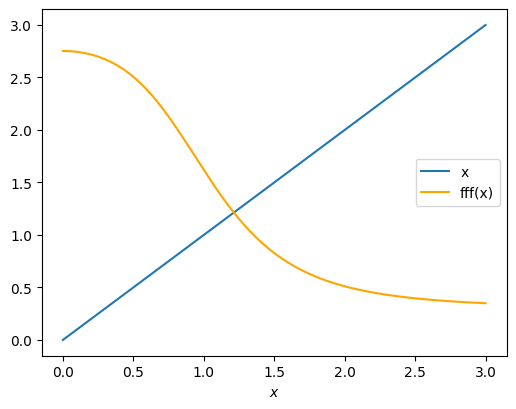

In [4]:
# Parameters
beta, n = 3, 2

# f(x)
f = lambda x: beta / (1 + x ** n)

# Make composition of functions
x = np.linspace(0, 3, 200)
fff = f(f(f(x)))

plt.figure(figsize=figsize)
plt.xlabel('$x$')
plt.plot(x, x, label="x")
plt.plot(x, fff, color="orange", label="fff(x)")
plt.legend()
plt.show()

Because the time derivative of $x_1$, $x_2$ and $x_3$ _all_ vanish at the fixed point, and we have shown that the fixed point is unique, we have
 
\begin{align}
x_1 = x_2 = x_3 \equiv x_0 = \frac{\beta}{1 + x_0^n},
\end{align}

or

\begin{align}
\beta = x_0(1+x_0^n).
\end{align}

Because we have a single fixed point, we cannot have multistability in the repressilator. So what happens at this fixed point?  To answer this question, we turn to **linear stability analysis**.

## Linear stability analysis

We first give a minimal introduction to the technique of linear stability analysis. The basic idea is that to approximate a *nonlinear* dynamical system by its Taylor series to first order near the fixed point and then look at the behavior of the simpler linear system.  The Hartman-Grobman theorem (which we will not derive here) ensures that the linearized system faithfully represents the phase portrait of the full nonlinear system near the fixed point.

Say we have a dynamical system with variables $\mathbf{u}$ with

\begin{align}
\frac{\mathrm{d}\mathbf{u}}{\mathrm{d}t} = \mathbf{f}(\mathbf{u}),
\end{align}

where $\mathbf{f}(\mathbf{u})$ is a vector-valued function, i.e.,

\begin{align}
\mathbf{f}(\mathbf{u}) = (f_1(u_1, u_2, \ldots), f_2(u_1, u_2, \ldots), \ldots).
\end{align}

Say that we have a fixed point $\mathbf{u}_0$.  Then, linear stability analysis proceeds with the following steps.

**1.** Linearize about $\mathbf{u}_0$, defining $\delta\mathbf{u} = \mathbf{u} - \mathbf{u}_0$.  To do this, expand $f(\mathbf{u})$ in a Taylor series about $\mathbf{u}_0$ to first order.
 
\begin{align}
\mathbf{f}(\mathbf{u}) = \mathbf{f}(\mathbf{u}_0) + \nabla \mathbf{f}(\mathbf{u}_0)\cdot \delta\mathbf{u} + \cdots,
\end{align}

where $\nabla \mathbf{f}(\mathbf{u}_0) \equiv \mathsf{A}$ is the Jacobi matrix,

\begin{align}
\nabla \mathbf{f}(\mathbf{u}_0) \equiv \mathsf{A} = \left.\begin{pmatrix}
\frac{\partial f_1}{\partial u_1} & \frac{\partial f_1}{\partial u_2} & \cdots \\[0.5em]
\frac{\partial f_2}{\partial u_1} & \frac{\partial f_2}{\partial u_2} & \cdots \\
\vdots & \vdots & \ddots
\end{pmatrix}\right|_{\mathbf{u}_0}.
\end{align}

Thus, we have

\begin{align}
\frac{\mathrm{d}\mathbf{u}}{\mathrm{d}t} = \frac{\mathrm{d}\mathbf{u}_0}{\mathrm{d}t} + \frac{\mathrm{d}\delta\mathbf{u}}{\mathrm{d}t}
= \mathbf{f}(\mathbf{u}_0) + \mathsf{A} \cdot \delta\mathbf{u} + \text{higher order terms}.
\end{align}

Since

\begin{align}
\frac{\mathrm{d}\mathbf{u}_0}{\mathrm{d}t} = \mathbf{f}(\mathbf{u}_0) = 0,
\end{align}

we have, to linear order,

\begin{align}
\frac{\mathrm{d}\delta\mathbf{u}}{\mathrm{d}t} \approx \mathsf{A} \cdot \delta\mathbf{u}.
\end{align}

This is now a system of _linear_ ordinary differential equations. If this were a one-dimensional system, the solution would be an exponential $\delta u \propto \mathrm{e}^{\lambda u}$. In the multidimensional case, the growth rate $\lambda$ is replaced by a set of eigenvalues of $\mathsf{A}$ that represent the growth rates in different directions, given by the eigenvectors of $\mathsf{A}$
 
**2.** Compute the eigenvalues $\lambda$ of $\mathsf{A}$.

**3.** Determine the stability of the fixed point using the following rules.

- If $\mathrm{Re}(\lambda) < 0$ for all $\lambda$, then the fixed point $\mathbf{u}_0$ is linearly stable.
- If $\mathrm{Re}(\lambda) > 0$ for any $\lambda$, then the fixed point $\mathbf{u}_0$ is linearly unstable. 
- If $\mathrm{Im}(\lambda) \ne 0$ for a linearly unstable fixed point, the trajectories spiral out, potentially leading to oscillatory dynamics.
- If $\mathrm{Re}(\lambda) = 0$ for one or more $\lambda$, with the rest having $\mathrm{Re}(\lambda) < 0$, then the fixed point $\mathbf{u}_0$ lies at a bifurcation.

So, if we can assess the dynamics of the linearized system near the fixed point, we can get an idea what is happening with the full system.

To do the linearization, we need to do Taylor expansions of Hill functions. We do this so often in this course, that we will write them here and/or memorize for future use.

\begin{align}
\frac{x^n}{1+x^n} &= \frac{x_0^n}{1+x_0^n} + \frac{n x_0^{n-1}}{(1+x_0^n)^2}\,\delta x + \text{higher order terms}, \\[1em]
\frac{1}{1+x^n} &= \frac{1}{1+x_0^n} - \frac{n x_0^{n-1}}{(1+x_0^n)^2}\,\delta x + \text{higher order terms}.
\end{align}

In the following we only need the second, repressing case.

## Linear stability analysis for the repressilator

To perform linear stability analysis for the repressilator, we begin by writing the linearized system.

\begin{align}
\frac{\mathrm{d}\delta x_1}{\mathrm{d}t} &\approx -\frac{\beta n x_0^{n-1}}{(1+x_0^n)^2}\,\delta x_3 - \delta x_1, \\[1em]
\frac{\mathrm{d}\delta x_2}{\mathrm{d}t} &\approx -\frac{\beta n x_0^{n-1}}{(1+x_0^n)^2}\,\delta x_1 - \delta x_2, \\[1em]
\frac{\mathrm{d}\delta x_3}{\mathrm{d}t} &\approx -\frac{\beta n x_0^{n-1}}{(1+x_0^n)^2}\,\delta x_2 - \delta x_3.
\end{align}

Defining

\begin{align}
a = \frac{\beta n x_0^{n-1}}{(1+x_0^n)^2},
\end{align}

we can write this in matrix form as

\begin{align}
\frac{\mathrm{d}}{\mathrm{d}t}\begin{pmatrix}
\delta x_1 \\
\delta x_2 \\
\delta x_3
\end{pmatrix}
= \mathsf{A}\cdot\begin{pmatrix}
\delta x_1 \\
\delta x_2 \\
\delta x_3
\end{pmatrix},
\end{align}

with

\begin{align}
\mathsf{A} = -\begin{pmatrix}
1 & 0 & a \\
a & 1 & 0 \\
0 & a & 1
\end{pmatrix}.
\end{align}

To compute the eigenvalues of $\mathsf{A}$, we compute the characteristic polynomial using cofactors,

\begin{align}
(1+\lambda)(1+\lambda)^2 + a(a^2) = (1+\lambda)^3 + a^3 = 0.
\end{align}

This is solved to give

\begin{align}
\lambda = -1 + a \sqrt[3]{-1}.
\end{align}

Recalling that there are three cube roots of $-1$, we get our three eigenvalues.

\begin{align}
&\lambda = -1 - a, \\[1em]
&\lambda = -1 + \frac{a}{2}(1 + i\sqrt{3}),\\[1em]
&\lambda = -1 + \frac{a}{2}(1-i\sqrt{3}).
\end{align}

The first eigenvalue is always real and negative.  The second two have a positive real part if $a > 2$;

\begin{align}
a = \frac{\beta n x_0^{n-1}}{(1 + x_0^n)^2} > 2.
\end{align}

Now, we previously derived that the fixed point $x_0$ satisfies

\begin{align}
\beta = x_0(1+x_0^n),
\end{align}

so

\begin{align}
a = \frac{\beta n x_0^{n-1}}{(1 + x_0^n)^2} = \frac{n x_0^n}{1 + x_0^n}.
\end{align}

So, $a>2$ only if $n > 2$, meaning that we _must_ have ultrasensitivity for the fixed point to be unstable.

At the bifurcation,

\begin{align}
a = \frac{n x_0^n}{1+x_0^n} = 2,
\end{align}

so

\begin{align}
x_0^n = \frac{2}{n-2}.
\end{align}

Again using $\beta = x_0(1+x_0^n)$, we can write

\begin{align}
\beta = \frac{n}{2}\left(\frac{n}{2} - 1\right)^{-\frac{n+1}{n}}
\end{align}

at the bifurcation.  So, for $n > 2$ and

\begin{align}
\beta > \frac{n}{2}\left(\frac{n}{2} - 1\right)^{-\frac{n+1}{n}},
\end{align}

we have imaginary eigenvalues with positive real parts. This is therefore an **oscillatory instability**.

## Solving for the fixed point

We have shown that there is a single fixed point, $x_1 = x_2 = x_3 \equiv x_0$ with 

\begin{align}
\beta = x_0(1 + x_0^n).
\end{align}

Getting an analytical solution of this equation for $x_0$ is usually impossible. We therefore seek a numerical method for finding $x_0$. This is an example of a **root finding problem**. It can be cast into a problem of finding $f(x) = 0$ for some function $f(x)$. Do not confuse this $f(x)$ with that defined in the previous sections to define the right hand side of the dynamical equations; we are using $f(x)$ here to be an arbitrary function. In the present case, $f(x) = \beta - x_0(1+x_0^n)$.

There are many algorithms for finding roots of functions. We will explore algorithms for doing so for the more general multidimensional case in future lessons. For now, we seek a scalar $x_0$. In this case, we know a lot about the fixed point. We know that it exists and is unique. We also know that it lies between $x_0 = 0$ (where $f(0) = \beta > 0$) and $x_0 = \beta$ (since $f(\beta) < 0$). When we have bounds and guarantees of uniqueness for a scalar root, we can use a **[bisection method](https://en.wikipedia.org/wiki/Bisection_method)** to find the root. The benefit of the bisection method is that it is guaranteed to find the root of the function $f(x)$ on an interval $[a,b]$, provided $f(x)$ is continuous and $f(a)$ and $f(b)$ have opposite sign, which is the case here. **[Brent's method](https://en.wikipedia.org/wiki/Brent%27s_method)** also has this guarantee, but is more efficient that using bisection. Brent's method is available in the `scipy.optimize.brentq()` function. It takes as an argument the function $f(x)$ whose root is to be found, and the left and right bounds for the root. We can write a function to find the fixed point for given $\beta$ and $n$.

In [5]:
def fixed_point(beta, n):
    return scipy.optimize.brentq(lambda x: beta - x*(1+x**n), 0, beta)

We can use this equation to map out the fixed point for various values of $\beta$ for given $n$.

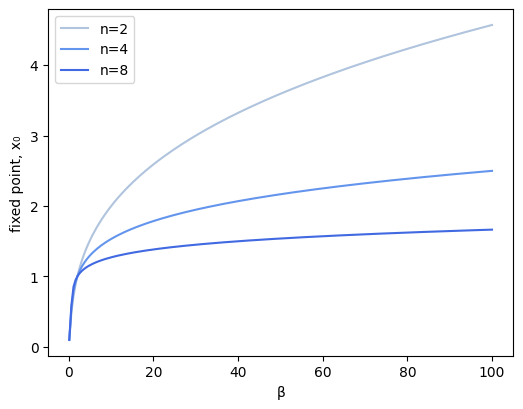

In [6]:
beta = np.linspace(0.1, 100, 200)

colors = ["lightsteelblue", "cornflowerblue", "royalblue"]

plt.figure(figsize=figsize)
plt.xlabel("β")
plt.ylabel("fixed point, x₀")

for n, color in zip([2, 4, 8], colors):
    plt.plot(beta, [fixed_point(b, n) for b in beta], color=color, label=f"n={n}")

plt.legend()
plt.show()

## Temporal dynamics

We can integrate the dynamical equations to see the levels of the respective proteins using interactive plotting of the result so we can see how the dynamics depend on the parameters $\beta$ and $n$. For sufficiently large $\beta$ and $n$, given by the linear stability relation we derived above,

\begin{align}
\beta > \frac{n}{2}\left(\frac{n}{2} - 1\right)^{-\frac{n+1}{n}},
\end{align}

we see oscillations. A few things to notice: 

* If you set $n<2$, oscillations diminish over time.
* If you set $n>2$, oscillations are sustained only for large enough $\beta$
* If you set $n=2$, see what happens...

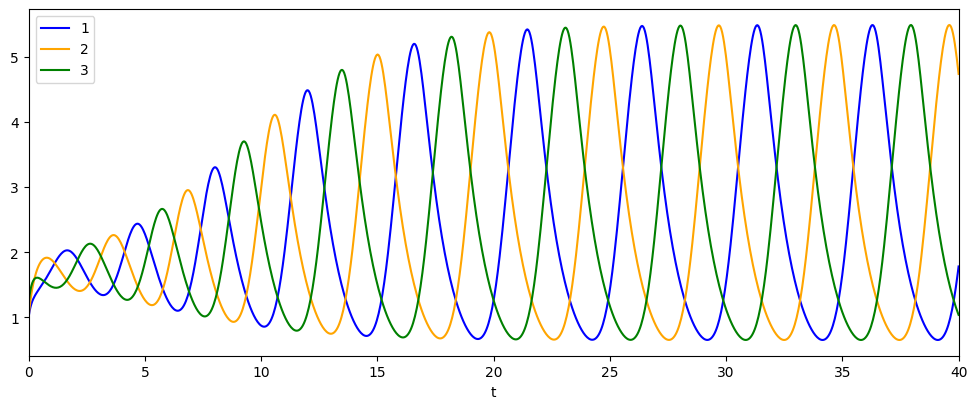

In [3]:
def repressilator_rhs(x, t, beta, n):
    """
    Returns 3-array of (dx_1/dt, dx_2/dt, dx_3/dt)
    """
    x_1, x_2, x_3 = x

    return np.array(
        [
            beta / (1 + x_3 ** n) - x_1,
            beta / (1 + x_1 ** n) - x_2,
            beta / (1 + x_2 ** n) - x_3,
        ]
    )


# Initial condiations
x0 = np.array([1, 1, 1.2])

# Number of points to use in plots
n_points = 1000

# parameters
beta = 10
n = 3
t_max = 40

# Solve for species concentrations
t = np.linspace(0, t_max, n_points)
x = scipy.integrate.odeint(repressilator_rhs, x0, t, args=(beta, n))
    
colors = ["blue", "orange", "green"]
    
plt.figure(figsize=(2*figsize[0],figsize[1]))
plt.xlabel("t")
plt.xlim(0, t_max)
   
for i, x_vals in enumerate(x.transpose()):
    plt.plot(t, x_vals, color=colors[i], label=str(i+1))

plt.legend()
plt.show()

## Trajectory in phase space

It is also instructive to plot the trajectory of the system as a projection in the $x_2$-$x_1$ plane (or in either of the other two planes this three-dimensional system can be projected onto).

When the fixed point is stable, the trajectory in the $x_2$-$x_1$ plane spirals into the fixed point. When it is unstable, the trajectory spirals away from it, eventually cycling around the fixed point to join a limit cycle.

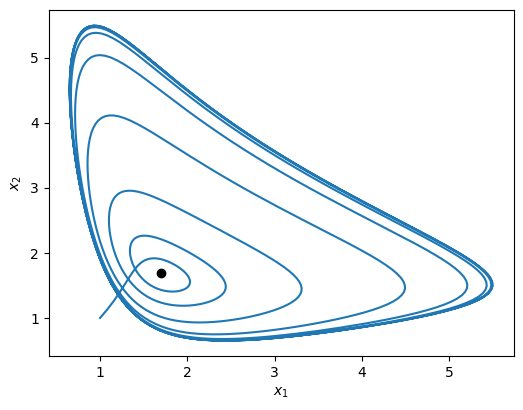

In [8]:
# parameters
beta = 10
n = 3
t_max = 40

# Solve for species concentrations
t = np.linspace(0, t_max, n_points)
x = scipy.integrate.odeint(repressilator_rhs, x0, t, args=(beta, n))
x1, x2, x3 = x.transpose()

# Solve for fixed point
x_fp = fixed_point(beta, n)

plt.figure(figsize=figsize)
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.plot(x1, x2)
plt.plot(x_fp, x_fp, marker="o", color="black")

plt.show()

## The limit cycle in 3D

Finally, here is a simple three-dimensional plot of the limit cycle in the space of the three protein concentrations.

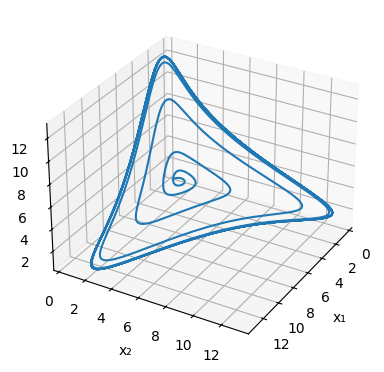

In [9]:
# Resolve problem for β = 20 and n = 3
t = np.linspace(0, 50, 1000)
x = scipy.integrate.odeint(repressilator_rhs, x0, t, args=(20, 3))

# Generate the plot
fig = plt.figure(figsize=figsize)
ax = fig.add_subplot(111, projection="3d")
ax.view_init(30, 30)
ax.plot(x[:, 0], x[:, 1], x[:, 2])
ax.set_xlabel("x₁")
ax.set_ylabel("x₂")
ax.set_zlabel("x₃");

## Linear stability analysis provides insight into repressilator design

It is useful to make a **linear stability diagram**, which is a map of parameter space highlighting stable and unstable regions.  We know the bifurcation line is

\begin{align}
\beta = \frac{n}{2}\left(\frac{n}{2} - 1\right)^{-\frac{n+1}{n}}
\end{align}

We can plot this line and delineate the regions of stability and instability. It clearly shows that, from a design point of view, it is desirable to make both $n$ and $\beta$ as high as possible.

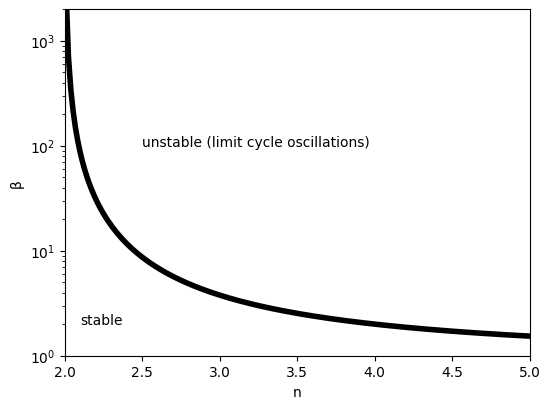

In [10]:
# Get bifurcation line
n = np.linspace(2.01, 5, 200)
beta = n / 2 * (n / 2 - 1) ** (-(1 + 1 / n))

plt.figure(figsize=figsize)
plt.xlabel("n")
plt.ylabel("β")
plt.yscale("log")
plt.xlim(2, 5)
plt.ylim(1, 2000)

plt.plot(n, beta, linewidth=4, color="black")

plt.annotate("stable", (2.1, 2))
plt.annotate("unstable (limit cycle oscillations)", (2.5, 100))

plt.show()

## Intuition from the protein-only model

This analysis shows two conditions that favor oscillations:

* High Hill coefficients 
* Strong promoters

In fact, these results can be understood intuitively: oscillations occur when the feedback "overshoots." The sharper and stronger the response as one goes around the complete feedback loop, the longer and higher a pulse in one factor can grow before it is, inevitably, yanked back down by the feedback. Consistent with this view, there is a tradeoff between the length of the cycle (number of repressors in the loop) and the minimum Hill coefficient required [Elowitz, PhD thesis, 1999](https://catalog.princeton.edu/catalog/2244277).

## Will it work?

It took a long time to design and then construct the repressilator. In addition to the molecular cloning, there were many steps to characterize the repressors and promoters and make sure signals could propagate through sequential repressor cascades. 

After all of this, there was more than a little uncertainty as to whether the system would, indeed, exhibit self-sustaining oscillations.

In [these movies](figs/repressilator_movie.mov), the changing fluorescence intensity in each cell provided a glimpse into the state of the oscillator over time:

<div style="margin: auto; width: 600px;">

<video src="figs/repressilator_movie.mov" style="width: 600px;" controls>Your browser does not support display of this video.</video>

</div>

This movie shows both clear oscillations in individual cells, as well as variability among cells in the amplitude, phase, and duration of each pulse. Analyzing these movies was done by manually tracking each cell backwards in time. This would now be done in a more automated fashion.

<div style="margin: auto; width: 200px;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/depressilator.png" alt="Depressilator">
</figure>
    
</div>

This procedure revealed clear oscillations in most cells, such as this:

<div style="margin: auto; width: 600px;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/repressilator_trace.png" alt="Repressilator trace">
</figure>
    
</div>


Analysis of many cells showed a typical repressilator period of 160 ± 40 min (SD, *n* = 63), with a cell division time of ≈50-60 min at 30°C. Sibling cells desynchronized with one another over about two cell cycles (95 ± 10 min). 

## Can the repressilator be improved?

In Potvin-Trottier et al, [Nature, 2016](https://doi.org/10.1038/nature19841), Johan Paulsson and colleagues asked what accounted for the repressilator's variability and whether it could be further improved. The following is based on [Gao & Elowitz, Nature, 2016](https://doi.org/10.1038/nature19478): 

* **Observationi method**. Instead of growth on agarose pads, where waste products can build up and influence cell growth and behavior, they switched to a microfluidic device developed by [Suckjoon Joon](https://jun.ucsd.edu/) termed "[the mother machine](https://doi.org/10.1016/j.cub.2010.04.045)," which allows continuous observation of single cells over hundreds of generations by trapping it at the end of a channel (for more info, see [Suckjoon's website](https://jun.ucsd.edu/mother_machine.php)). This revealed that, despite its variability, the original repressilator exhibited self-sustaining oscillations that never terminate.

* **Integration of reporter**. Now able to analyze the dynamics in more constant conditions, they found that much of this variation could be attributed to the reporter plasmid itself. Integrating the reporter into the repressilator plasmid reduced this variability, as seen in the [movie](figs/integrated_reporter_movie.mov) and traces below.

<div style="margin: auto; width: 300px;">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/reporter_integrated_repressilator.png" alt="reporter integrated repressilator">
</figure>
    
</div>

<div style="margin: auto; width: 600px;">

<video src="figs/integrated_reporter_movie.mov" style="width: 600px;" controls>Your browser does not support display of this video.</video>

</div>


<div style="margin: auto; width: 600px;">

<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/integrated_reporter_traces.png" alt="integrated reporter traces">
</figure>
    
</div>

* **The problem with TetR**. A nice property of TetR is that it binds extremely tightly to its operator site. But this tightness of binding creates a problem as well. It means that the timing of de-repression by TetR depends sensitively on when the final molecules of TetR are degraded or diluted from the cell, as shown in the following figure from Potvin-Trottier et al. This leads to variability in the overall period. However, this effect can be mitigated by inclusion of a "DNA sponge"–a plasmid containing extra TetR binding sites. (In fact, in the original repressilator design the reporter plasmid fortuitously played this role.)

<div style="margin: auto; width: 400px;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/TetR_decay.png" alt="TetR decay">
</figure>
    
</div>

* **Degradation machinery**. Finally, an additional source of variability stemmed from fluctuations in the protein degradation machinery. This could be circumvented by reducing the amounts of repressor made, or eliminating their degradation altogether. Of course, without protein degradation, oscillation periods stretch out to as much as 14 cell cycles, but with such a high precision that it would take 180 cell cycles to accumulate a half-period of phase drift! A remarkably precise clock. 

Here, with three colors to allow simultaneous observation of all three repressors, is one of the final repressilator designs as [a movie](figs/repressilator_titration_sponge_movie.mov) and a typical trace.

<div style="margin: auto; width: 600px;">

<video src="figs/repressilator_titration_sponge_movie.mov" style="width: 600px;" controls>Your browser does not support display of this video.</video>

</div>


<div style="margin: auto; width: 400px;">
  
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/accurate_repressilator_trace.png" alt="accurate repressilator trace">
</figure>
    
</div>

In fact, this is so accurate that you can [see it in a test tube](figs/repressilator_in_a_tube.mp4).

<div style="margin: auto; width: 400px;">

<video src="figs/repressilator_in_a_tube.mp4" style="width: 400px;" controls>Your browser does not support display of this video.</video>

</div>

Or you can see it in the "tree rings" of a bacterial colony.

<div style="margin: auto; width: 400px;">
    
<figure style="width: 100%; margin: auto; padding: 20px;">
  <img src="figs/repressilator_tree_ring.png" alt="repressilator tree ring">
</figure>
    
</div>


## Conclusions

* Limit cycles are stable orbits in phase space. Circuits that generate limit cycle dynamics are ideal for self-sustaining oscillations in living cells.
* The repressilator uses a cycle of three repressors to create a delayed negative feedback loop.
* Linear stability analysis allows us to determine the stability of a fixed point.
* The simplified protein-only repressilator model has a single fixed point, and generates limit cycle oscillations when this point becomes unstable.
* High Hill coefficients and strong promoters favor oscillations.
* The model can be extended from 3 to 6 variables to include mRNA as well as proteins. 
* The extended model further shows that destabilizing proteins to make the decay rates of mRNA and protein more similar should also favor oscillations and reduce the minimum Hill coefficient required for oscillations.
* A repressilator designed to meet these conditions shows self-sustaining oscillations in individual *E. coli* cells.
* Recently, several features of this circuit were improved to create an oscillator of astonishing precision.
* Further, this oscillator has now been used to record the growth dynamics of E. coli cells in mouse gut. For more details, see [Riglar et al, Nature Comm., 2019](https://doi.org/10.1038/s41467-019-12638-z). 